In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from src.parameters import FIGURE_DIR

# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'axes.labelsize': 9,
    'text.color': '#222222',
    'font.sans-serif' : 'Helvetica',
    'text.usetex': False,
    'figure.figsize': (7.2, 4.45),
    'xtick.major.size': 0.00,
    'ytick.major.size': 0.00,
    'axes.labelpad': 0.1,
    }
sns.set(style='white', context='paper', rc=rc_params,
        font_scale=1.0)

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

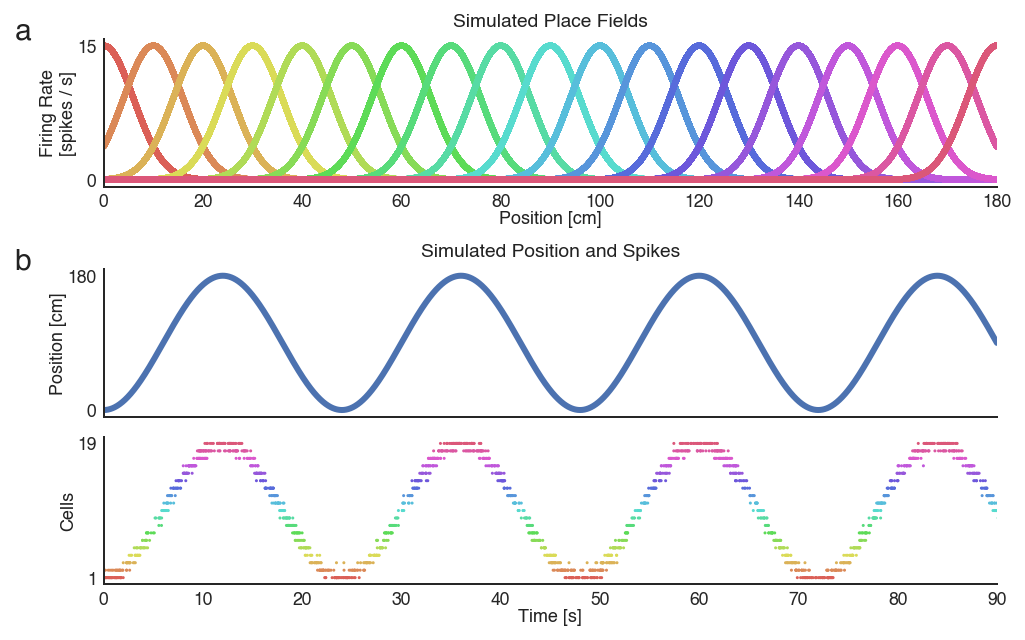

In [75]:
from src.sorted_spikes_simulation import make_simulated_run_data
from src.figure_utilities import TWO_COLUMN, GOLDEN_RATIO

TRACK_HEIGHT = 180
PLACE_FIELD_MEANS = np.arange(0, TRACK_HEIGHT + 10, 10)

time, linear_distance, sampling_frequency, spikes, place_fields = make_simulated_run_data(place_field_means=PLACE_FIELD_MEANS)
spike_ind, neuron_ind = np.nonzero(spikes)
n_neurons = spikes.shape[1]
colors = sns.color_palette("hls", n_neurons)

fig, axes = plt.subplots(3, 1, figsize=(TWO_COLUMN, TWO_COLUMN * GOLDEN_RATIO), constrained_layout=True)
for place_field, color in zip(place_fields.T, colors):
    axes[0].plot(linear_distance, place_field, linewidth=3, color=color)
axes[0].set_xlabel('Position [cm]')
axes[0].set_ylabel('Firing Rate\n[spikes / s]')
axes[0].set_title('Simulated Place Fields')
axes[0].set_xlim((linear_distance.min(), linear_distance.max()))
axes[0].set_yticks([0, np.round(place_fields.max())])
axes[0].text(-0.10, 1.0, 'a', transform=axes[0].transAxes, 
        size=15, weight='extra bold')

axes[1].plot(time, linear_distance, linewidth=3)
axes[1].set_ylabel('Position [cm]')
axes[1].set_title('Simulated Position and Spikes')
axes[1].set_yticks([0, np.round(linear_distance.max())])
axes[1].set_xticks([])
axes[1].set_xlim((0.0, 90.0))
axes[1].text(-0.10, 1.0, 'b', transform=axes[1].transAxes, 
        size=15, weight='extra bold')

c = [colors[ind] for ind in neuron_ind]
axes[2].scatter(time[spike_ind], neuron_ind + 1, c=c, s=0.5)
axes[2].set_yticks((1, spikes.shape[1]))
axes[2].set_ylabel('Cells')

axes[2].set_xlabel('Time [s]')
axes[2].set_xlim((0.0, 90.0))

sns.despine()

In [175]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var

movement_var = estimate_movement_var(linear_distance, sampling_frequency)

discrete_diag = 0.95
continuous_transition_types = (
    [['random_walk', 'uniform', 'identity'],
     ['uniform', 'uniform', 'uniform'],
     ['random_walk', 'uniform', 'identity']])

classifier = SortedSpikesClassifier(movement_var=1,
                                    replay_speed=10,
                                    spike_model_penalty=0.5,
                                    discrete_transition_diag=discrete_diag,
                                    continuous_transition_types=continuous_transition_types,
                                    place_bin_size=2.0, infer_track_interior=False)
classifier.fit(linear_distance, spikes)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[['random_walk', 'uniform',
                                                     'identity'],
                                                    ['uniform', 'uniform',
                                                     'uniform'],
                                                    ['random_walk', 'uniform',
                                                     'identity']],
                       discrete_transition_diag=0.95,
                       discrete_transition_type='strong_diagonal',
                       infer_track_interior=False,
                       initial_conditions_type='uniform_on_track',
                       knot_spacing=10, movement_var=1, place_bin_size=2.0,
                       position_range=None, replay_speed=10,
                       spike_model_penalty=0.5)

### Slow Gamma (30 Hz) with jumps/continuous in the trough and hovers elsewhere

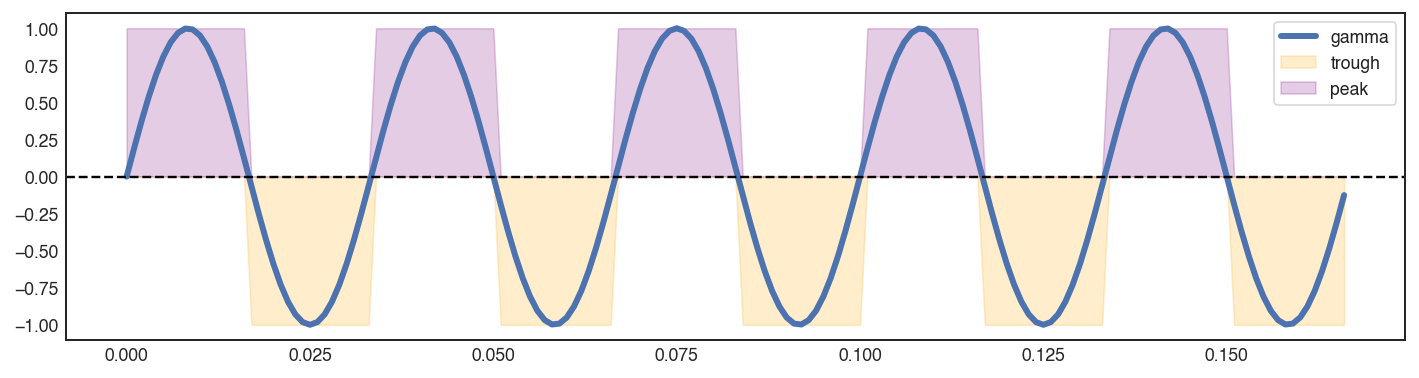

In [5]:
freq = 30
replay_time = np.arange(167) / 1000
gamma = np.sin(freq * 2 * np.pi * replay_time)

plt.figure(figsize=(12, 3))
plt.plot(replay_time, gamma, linewidth=3, label='gamma')
plt.axhline(0, color='black', linestyle='--')
is_trough = gamma < 0
plt.fill_between(replay_time, -1 * is_trough, alpha=0.2, color='orange', label='trough')
plt.fill_between(replay_time, ~is_trough, alpha=0.2, color='purple', label='peak')
plt.legend()

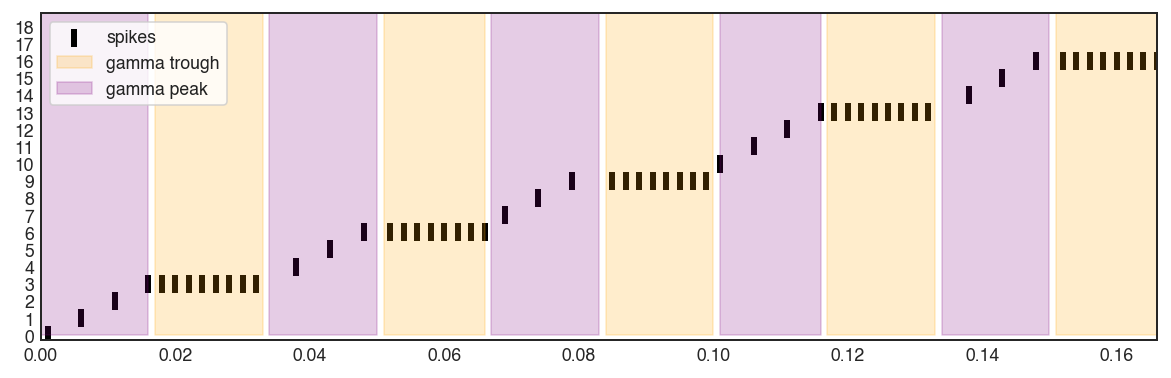

In [98]:
from scipy.ndimage import label

n_neurons = spikes.shape[1]
n_time = replay_time.shape[0]

test_spikes = np.zeros((n_time, n_neurons))

n_peak_time = (~is_trough).sum()
step_size = 5

continuous_spikes = np.zeros((n_neurons * step_size, n_neurons))
continuous_spikes[(np.arange(0, n_neurons * step_size, step_size) + 1, np.arange(n_neurons))] = 1.0
test_spikes[~is_trough] = continuous_spikes.copy()[:n_peak_time]

n_hover_time = is_trough.sum()
hover_spikes = np.zeros((n_hover_time, n_neurons))
labels, max_label = label(~is_trough)
hover_neuron_inds = [np.nonzero(test_spikes[labels == label])[1].max()
                    for label in np.arange(1, max_label+1)]

labels, max_label = label(is_trough)

for label, hover_neuron_ind in zip(np.arange(1, max_label+1), hover_neuron_inds):
    spike_time_ind = np.nonzero(labels == label)[0][1::2]
    test_spikes[spike_time_ind, hover_neuron_ind] = 1.0


spike_time_ind, neuron_ind = np.nonzero(test_spikes)

plt.figure(figsize=(10, 3))
plt.scatter(replay_time[spike_time_ind], neuron_ind, label='spikes', color='black', marker='|', s=80, linewidth=3)
plt.fill_between(replay_time, is_trough * n_neurons, alpha=0.2, color='orange', label='gamma trough', where=is_trough)
plt.fill_between(replay_time, ~is_trough * n_neurons, alpha=0.2, color='purple', label='gamma peak',  where=~is_trough)
plt.xlim((replay_time.min(), replay_time.max()))
plt.ylim((-0.25, n_neurons - 0.25))
plt.yticks(np.arange(n_neurons))
plt.legend()

In [44]:
from src.parameters import TRANSITION_TO_CATEGORY, STATE_COLORS

def plot_classification(replay_time, test_spikes, results, is_trough, is_causal=False):
    posterior_type = 'causal_posterior' if is_causal else 'acausal_posterior'
    results = results.assign_coords(
        state=lambda ds: ds.state.to_index()
        .map(TRANSITION_TO_CATEGORY))
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=80, linewidth=3)
    axes[0].set_yticks((0, test_spikes.shape[1]))
    axes[0].set_ylabel('Neuron Index')
    axes[0].fill_between(replay_time, is_trough * n_neurons, alpha=0.2, color='orange', label='gamma trough', where=is_trough)
    axes[0].fill_between(replay_time, ~is_trough * n_neurons, alpha=0.2, color='purple', label='gamma peak', where=~is_trough)
    axes[0].legend(loc='upper left')
    
    replay_probability = results[posterior_type].sum('position')
    for state, prob in replay_probability.groupby('state'):
        axes[1].plot(prob.time, prob.values, linewidth=4, label=state, color=STATE_COLORS[state])
    axes[1].set_ylabel('Probability')
    axes[1].set_yticks([0, 1])
    axes[1].set_ylim((-0.01, 1.05))
    axes[1].fill_between(replay_time, is_trough * n_neurons, alpha=0.2, color='orange', label='gamma trough', where=is_trough)
    axes[1].fill_between(replay_time, ~is_trough * n_neurons, alpha=0.2, color='purple', label='gamma peak', where=~is_trough)

    results[posterior_type].sum('state').plot(
        x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    axes[2].set_ylabel('Position [cm]')
    plt.xlim((replay_time.min(), replay_time.max()))
    axes[-1].set_xlabel('Time [ms]')
    for change_point in replay_time[np.nonzero(np.diff(is_trough) > 0)[0]]:
        axes[-1].axvline(change_point, color='white', alpha=0.25, linestyle='--')
    sns.despine()

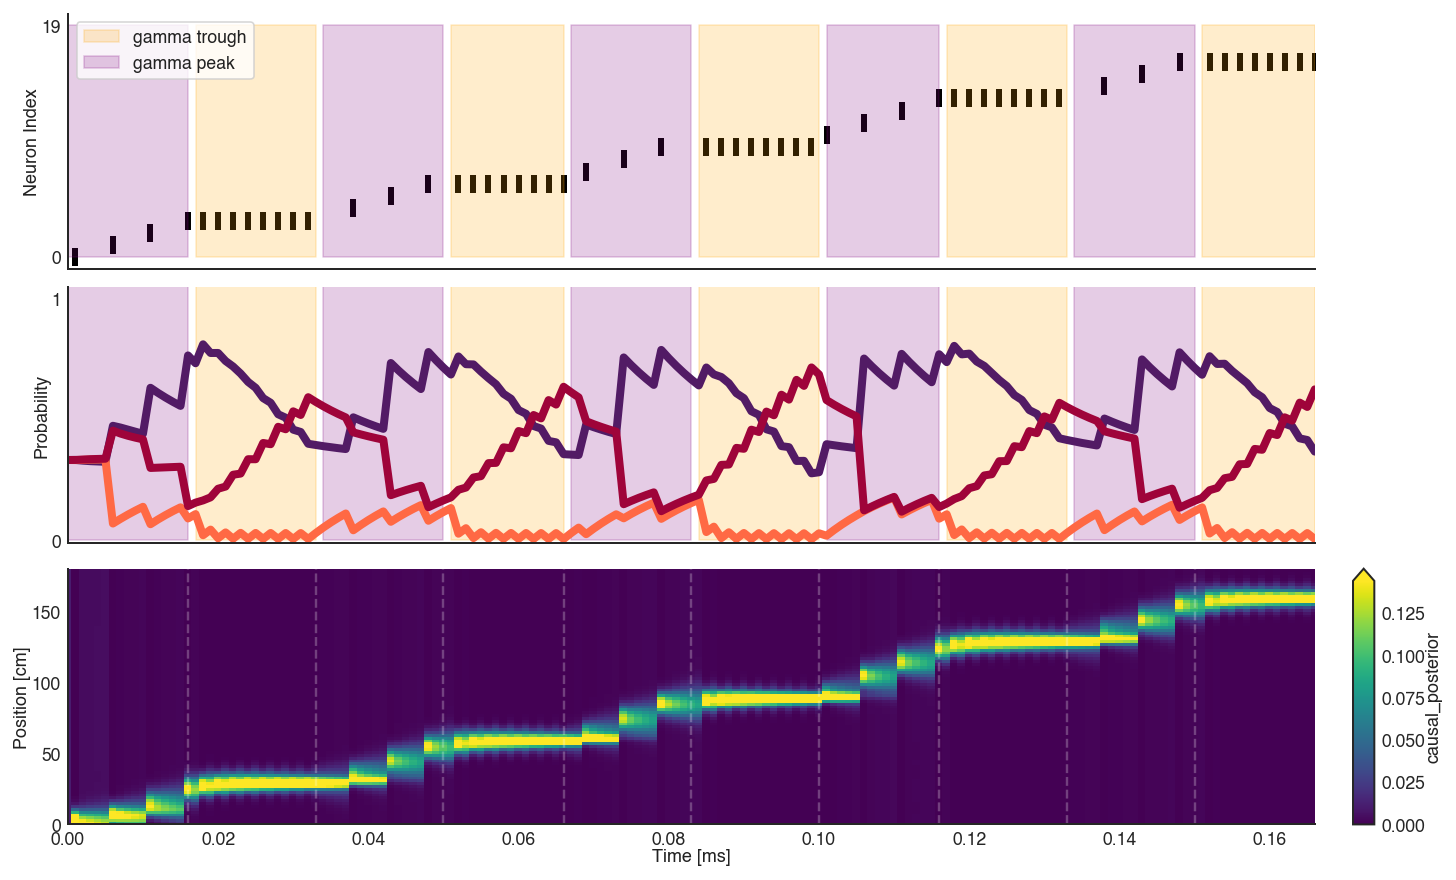

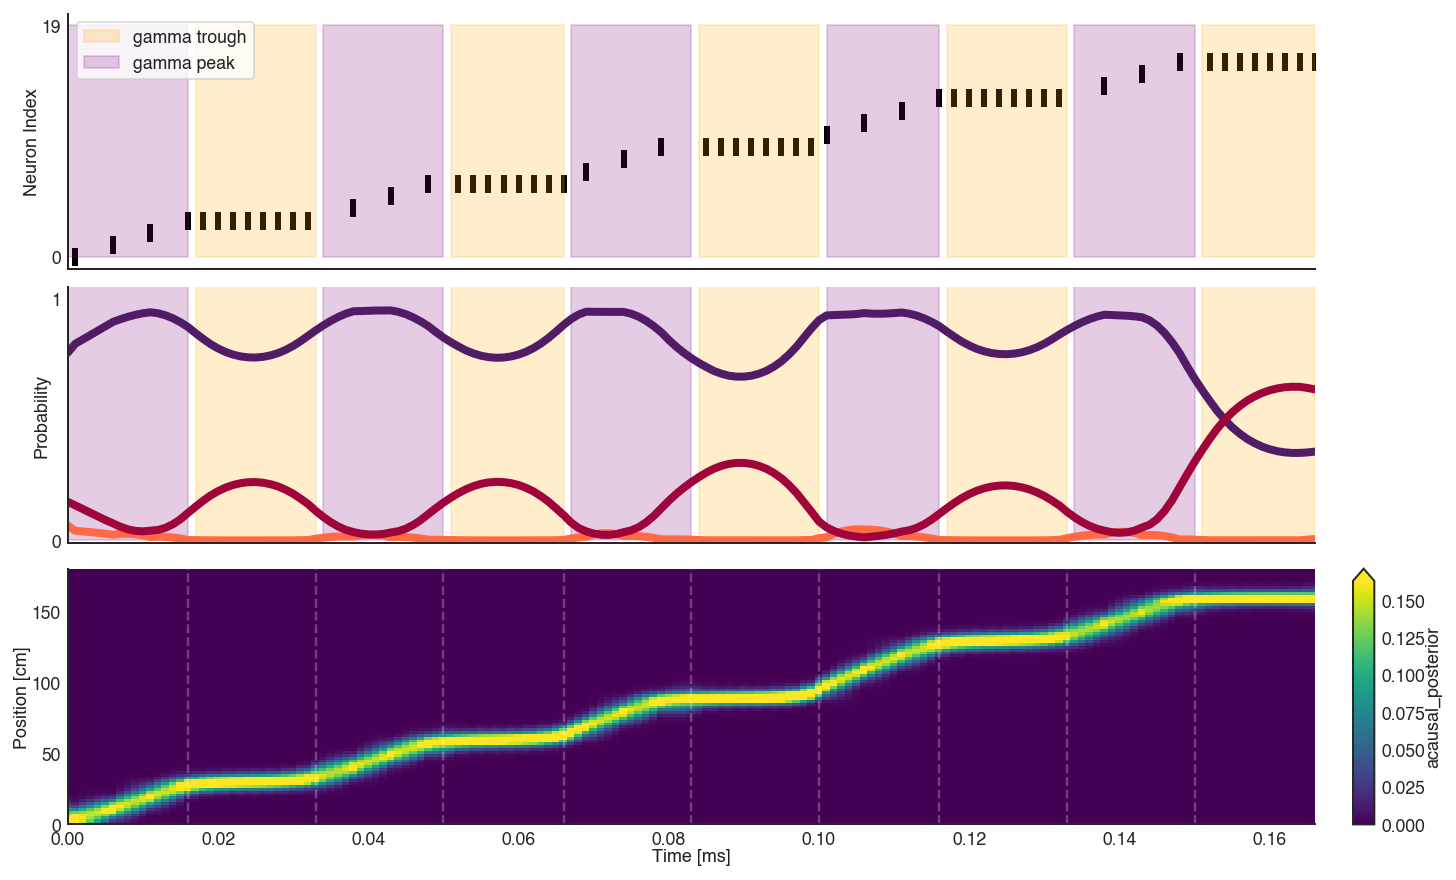

In [176]:
results = classifier.predict(test_spikes, time=replay_time)
plot_classification(replay_time, test_spikes, results, is_trough, is_causal=True)
plot_classification(replay_time, test_spikes, results, is_trough, is_causal=False)

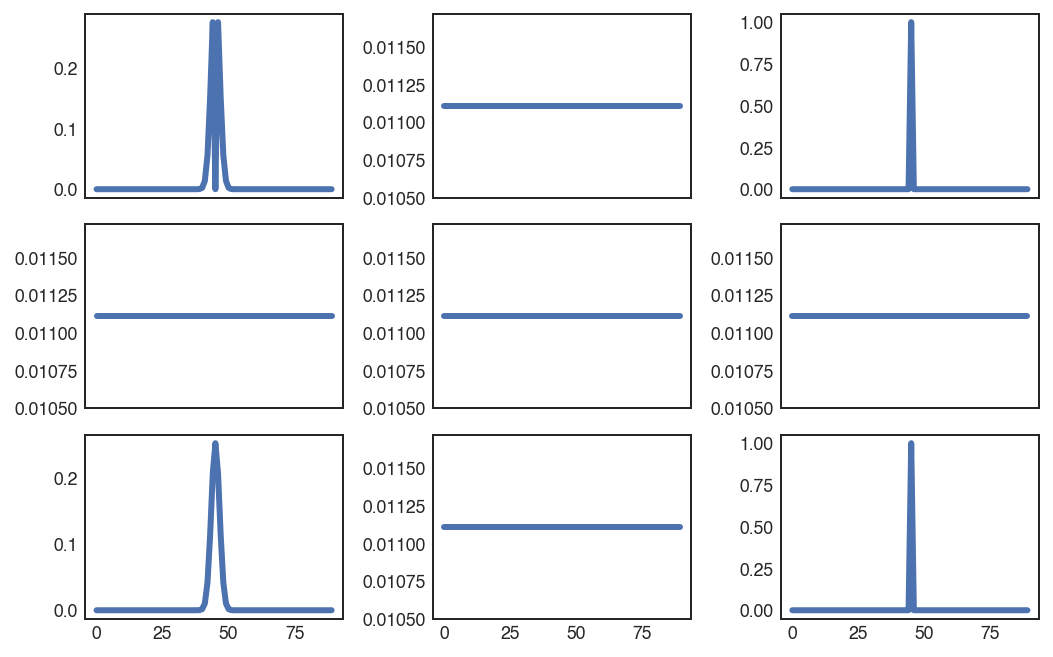

In [173]:
fig, axes = plt.subplots(3, 3, constrained_layout=True, sharex=True)
n_place_bins = classifier.place_bin_centers_.size
transitions = classifier.continuous_state_transition_.reshape(-1, n_place_bins, n_place_bins)

for transition, ax in zip(transitions, axes.flat):
    ax.plot(transition[n_place_bins // 2, :], linewidth=3)

In [174]:
from ipywidgets import interact

n_time = results.time.size

@interact(time_ind=(0, n_time-1))
def plot_posterior_movie(time_ind=0, posterior_type='causal_posterior'):
    results[posterior_type].isel(time=time_ind).plot(x='position', col='state')
    results['likelihood'].isel(time=time_ind).plot(x='position', col='state')
    plt.ylim((0, 1))

interactive(children=(IntSlider(value=0, description='time_ind', max=166), Text(value='causal_posterior', desc…